In [1]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"no_gravity"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
Delta_folder = f"Shared/Deltas"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

## Inspect number density files

In [ ]:
# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Incl. primordial fluctuations
# note: all sky densities are computed for 5 specific masses
pix_dens_PF = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
print(pix_dens_PF.shape)
print(tot_dens_PF.shape)

Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
print(Deltas.shape)

## Overdensity band

ic| tot_dens_halos.shape: (1, 50)
ic| tot_dens_halos_PFs.shape: (1, 5)


[0.99980662 0.99991533 0.99996537 0.99998683 0.99999537 0.9999985
 0.99999956 0.99999988 0.99999997 0.99999999]
[1.41968651e-01 9.62331085e+00 7.19209874e+01 6.18840938e+02
 2.14910184e+03]


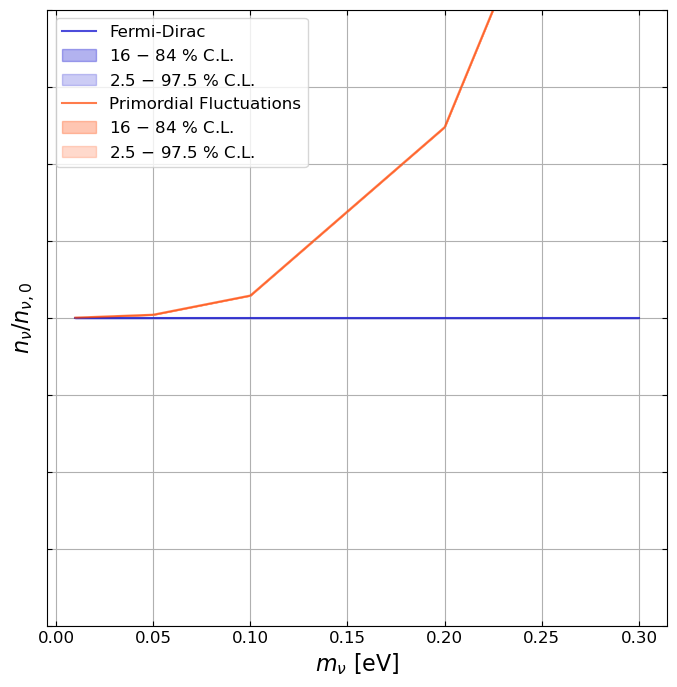

In [2]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
ic(tot_dens_halos.shape)

tot_dens_halos_PFs = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
ic(tot_dens_halos_PFs.shape)


eta = 1*1e3
SimPlot.overdensity_band(
    dens_FD=tot_dens_halos,
    dens_PF=tot_dens_halos_PFs,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    plot_ylims=((0-eta),(0+eta)),
    plot_log=False,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}.pdf",
    args=Params())

## CNB anisotropy x DM line-of-sight skymaps

ic| CNB_dens_1mass.shape: (768,)
ic| CNB_dens_1mass.min(): Array(0.07370979, dtype=float64)
    CNB_dens_1mass.max(): Array(0.07370979, dtype=float64)


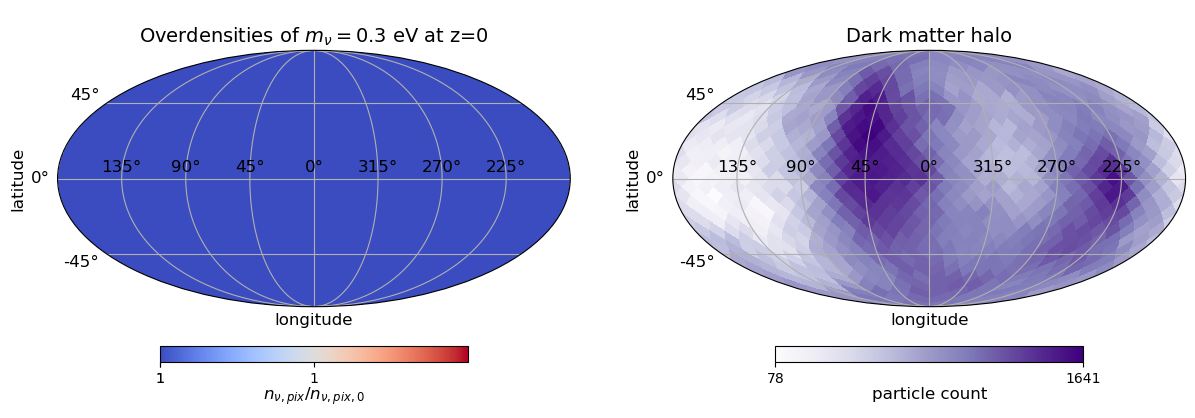

In [4]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.3
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())

## Phase-space distributions today

ic| Deltas_sort.shape: (1, 5, 768, 1000)
ic| p_z4_sort.shape: (1, 5, 768, 1000)


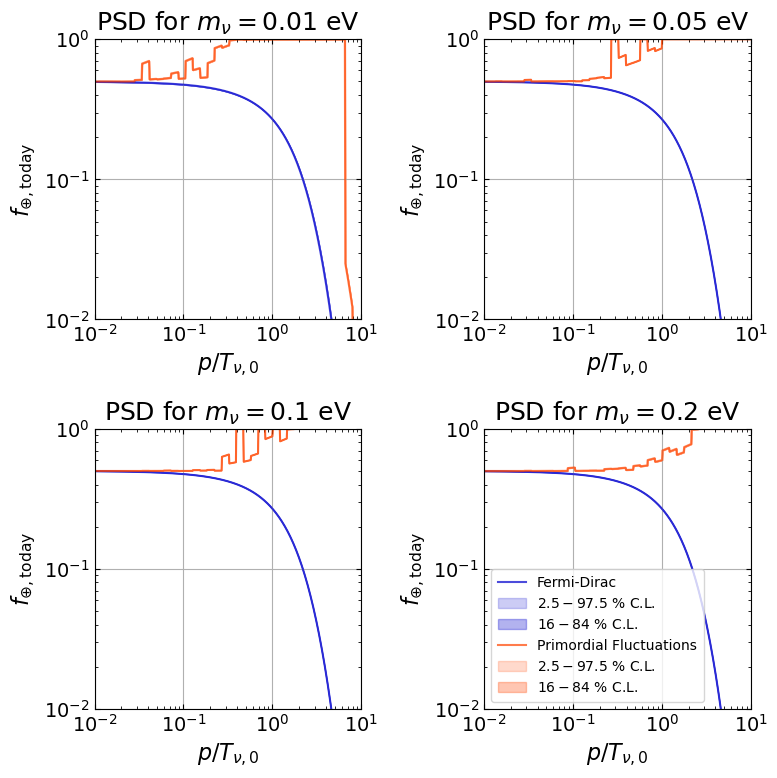

In [5]:
def most_clustered():
    ...
    # splits up momentum/velocity arrays into blocks?
def halo_parameters():
    ...
def escape_momentum():
    ...


SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=1, 
    fig_dir=fig_folder)

## Temperature fluctuation skymaps from Cl

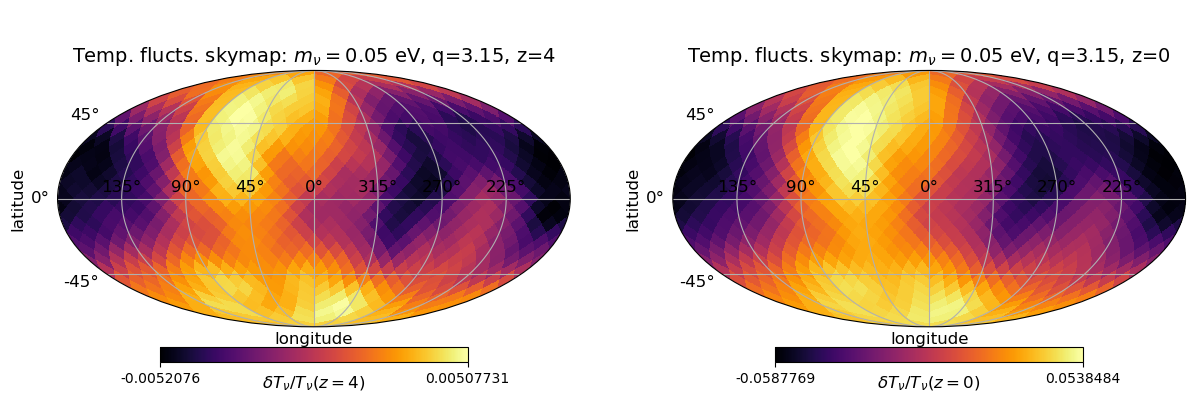

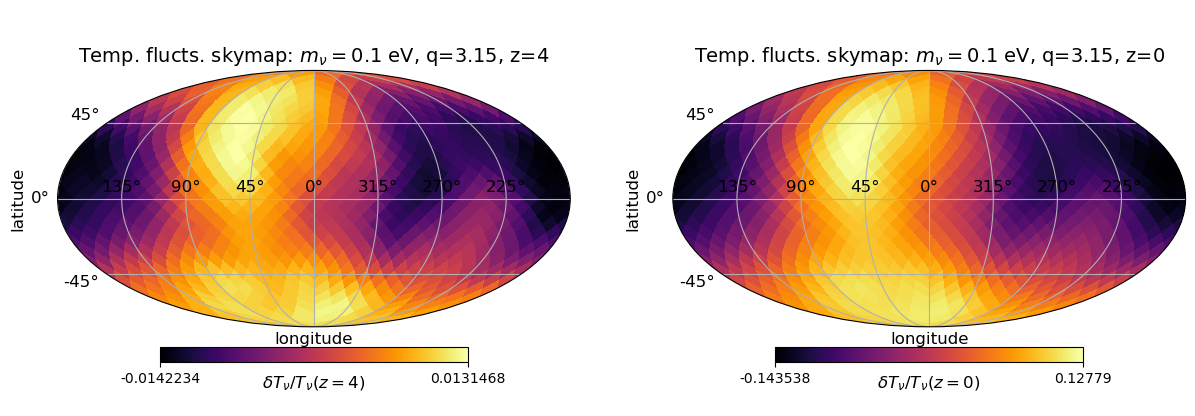

In [6]:
SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.1, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

In [7]:
print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
conv_unit = Primordial.uK/Params.T_CNB*100
TZ_val_left = -176166*conv_unit
TZ_val_right = 157773*conv_unit
print(f"{TZ_val_left:.4f} to {TZ_val_right:.4f} % of T_CNB")

Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:
-9.0235 to 8.0814 % of T_CNB


## Comparison of FD & PF skymaps

ic| FD_skymap.sum()*N0_pix/(Params.cm**-3): Array(56.60787029, dtype=float64)
ic| PF_skymap.sum()*N0_pix/(Params.cm**-3): Array(9521808.87023941, dtype=float64)


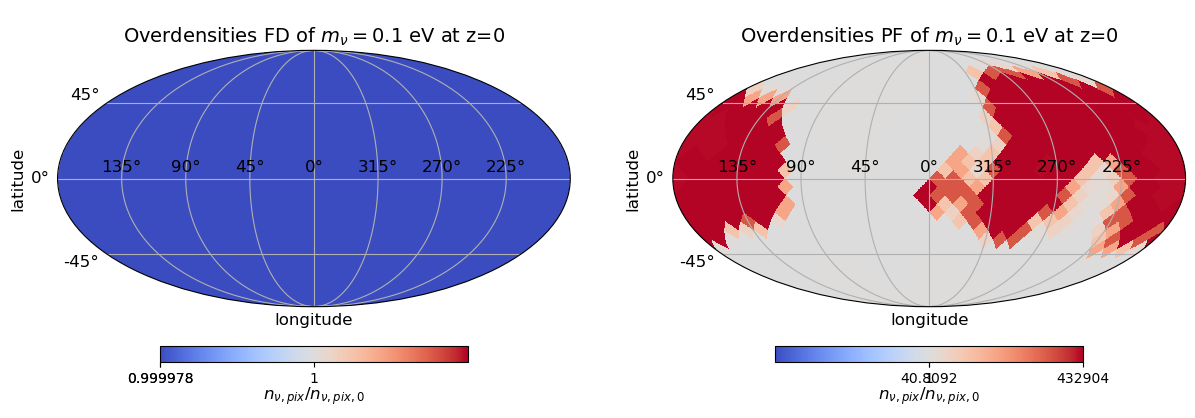

In [10]:
# Choose a halo and mass to display
halo_i = 1  #note: only halo_i=1 for no_gravity (just a label, sim doens't contain any halos)
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)

### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
ic(FD_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF[halo_i, mPF_i, :] / skymap_norm
ic(PF_skymap.sum()*N0_pix/(Params.cm**-3))

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)  

## Comparison of FD & PF power spectra

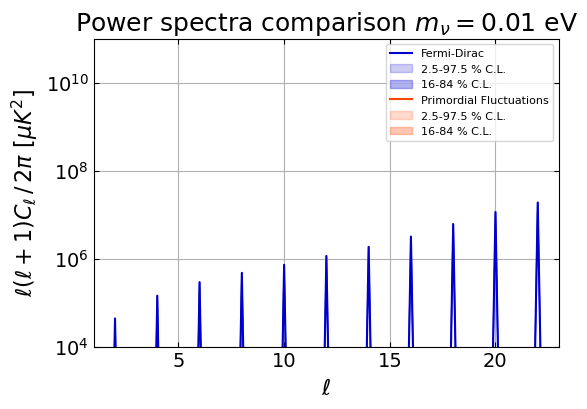

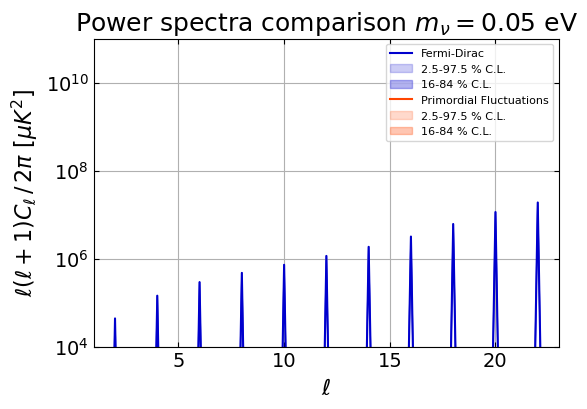

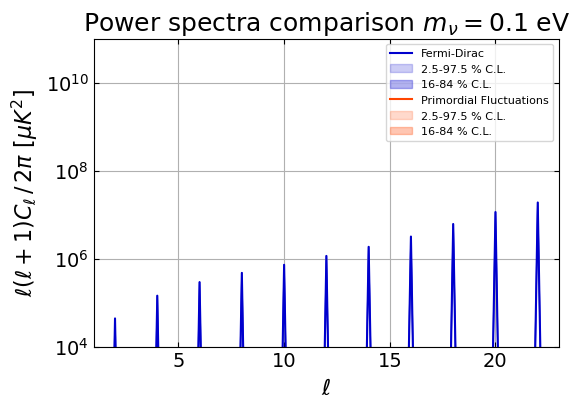

In [11]:
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)